In [1]:
import numpy as np
from scipy.fft import dct
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def get_DCT_matrix(size):
    '''Returns the normalised square matrix, used in the computation of the Discrete Cosine Transform
    
    Argument:
    size: the size of the matrix, which is the size of each basis vector. This must be equal to the length 
            of the signal to be transformed, obviously
    
    Returns:
    DCT_matrix: The required DCT matrix
    '''
    # initializing x and m
    x = np.arange(start = 0, stop = size).reshape(1, size) # row vector
    x = 2*x+1
    m = np.arange(start = 0, stop = size).reshape(size, 1) # column vector
    
    # the outer product
    matrix = np.dot(m,x)
    
    # taking the cosine
    DCT_matrix = np.cos(matrix* np.pi /2 / size)
    
    # normalizing, dividing each basis by its magnitude
    #DCT_matrix[0, :] *= np.sqrt(1/size)
    #DCT_matrix[1:,:] *= np.sqrt(2/size)
    
    return DCT_matrix

In [3]:
DCT_MATRIX = get_DCT_matrix(8)
# where our image blocks are 8x8

In [4]:
def DCT_2D (in_block):
    '''computes the DCT transform of the incoming signal
    Arguments:
    in_block: the input 2D signal

    
    Returns:
    dct_coeff: The normalised DCT coefficients corresponding to this block
    '''
    
    # First some input validation
    row, col = in_block.shape
    assert (row == 8 and col == 8)
    
    #DCT computation
    Intermediate = np.dot(DCT_MATRIX, in_block)
    dct_coeff = np.dot(Intermediate, DCT_MATRIX.T)
    
    #scaling
    dct_coeff[0,0] /= 64
    dct_coeff[0,1:]/=32
    dct_coeff[1:,0] /= 32
    dct_coeff[1:,1:] /= 16
    
    return dct_coeff
    

In [5]:
def IDCT_2D(in_block):
    '''computes the IDCT transform of the incoming DCT coefficients block
    Arguments:
    in_block: the input 2D DCT coefficients

    
    Returns:
    inverted: The result of the IDCT
    '''
    # First some input validation
    row, col = in_block.shape
    assert (row == 8 and col == 8)
    
    #DCT computation
    
    Intermediate = np.dot(DCT_MATRIX.T, in_block)
    inverted = np.dot(Intermediate, DCT_MATRIX)
    
    return inverted
    

In [6]:
# testing the DCT/IDCT pair
# generate the array
x = np.random.randn(8,8)* 100
# generate the DCT matrix
big_x = DCT_2D(x)
# get the IDCT
ret_x = IDCT_2D(big_x)
# get the Sum of abs errors
error_2 = np.sum(abs(ret_x-x))
print("The sum of absolute errors is:",error_2)

The sum of absolute errors is: 3.5360048222798923e-12


In [7]:
LOW_COMPRESSION_MAT = np.array([[1,1,1,1,1,2,2,4],
                                [1,1,1,1,1,2,2,4], 
                                [1,1,1,1,2,2,2,4], 
                                [1,1,1,1,2,2,4,8],
                                [1,1,2,2,2,2,4,8],
                                [2,2,2,2,2,4,8,8],
                                [2,2,2,4,4,8,8,16],
                                [4,4,4,4,8,8,16,16]
                               ])

HIGH_COMPRESSION_MAT = np.array([[1,2,4,8,16,32,64, 128],
                                 [2,4,4,8,16,32,64, 128],
                                 [4,4,8,16,32,64,128,128],
                                 [8,8,16,32,64,128,128,256],
                                 [16,16,32,64,128,128,256,256],
                                 [32,32,64,128,128,256,256,256],
                                 [64,64,128,128,256,256,256,256],
                                 [128,128,128,256,256,256,256,256]
                                ])
ONES_TABLE = np.ones((8,8))

In [8]:
def divide_quant(block, q_table = ONES_TABLE):
    '''Divides the each element in the block by the corresponding element in the Quantization table, then rounds
    
    Arguments:
    block: The block to be divided by the table
    q_table: The Quantization table "ones by default"
    
    Returns: The result of dividing, then rounding
    '''
    res = block / q_table
    res = res.astype(np.int) # rounding
    return res

In [9]:
# At the decoder, we multiply by the Q_table
def multiply_quant(block, q_table = ONES_TABLE):
    return block * q_table

In [10]:
def get_ZigZag_indices(size):
    '''Returns the order of indeces to be parsed in zigzag parsing
    
    Arguments:
    size: The size of the square matrix to be parsed
    
    Returns:
    indeces: indeces ordered according to zigzag parsing
    '''
    
    # this will hold the first half
    indeces = []
    # this will hold the second half indeces
    reversed_indeces = []
    
    for i in range(size):
        for j in range(i+1):
            # if odd
            if i%2 != 0:
                indeces.append((j, i-j))
                reversed_indeces.append((size-1-j, size-1-i+j))
            # if even
            else:
                indeces.append((i-j, j))
                reversed_indeces.append((size-1-i+j,size-1-j))
    
    # reverse
    reversed_indeces = reversed_indeces[::-1]
    # exclude the main diagonal part because it is repeated
    indeces = indeces[:-size]
    # merge the two lists
    indeces.extend(reversed_indeces)
    
    return indeces

In [11]:
# the ZIGZAG indices will be a global variable.
ZIG_ZAG_INDICES = get_ZigZag_indices(8)
ZIG_ZAG_ROW, ZIG_ZAG_COL = zip(* ZIG_ZAG_INDICES)

In [12]:
def encode_runlength(array):
    '''Returns the encoded array using runlength code
    The function will apply runlength to "0" because it is the most occuring element 
    
    Arguments:
    array: a 1D numpy array to be encoded
    
    Returns: a 1D list, encoded using runlength
    '''
    encoded = []
    counter = 0
    
    # this for loop will handle zeros that are interrupted before array ends
    for element in array:
        if (element == 0):                          #if element is zero, increment counter
            counter += 1
        else:                                       # if not, check if we were in a zero sequence
            if (counter != 0):
                # zero sequence interrupted
                encoded.extend([0, counter])
                # reset counter
                counter = 0
            
            # add the non zero element to the array 
            encoded.append(element)
            
    # This handles trailing zeros
    if counter != 0:
        encoded.extend([0, counter])
    return encoded

In [13]:
arr = np.random.randint(2, size = 10)
enc = encode_runlength(arr)
print("original array is", arr,"with length", len(arr))
print("encoded sequence is", enc, "with length", len(enc))

original array is [0 0 1 0 1 0 1 1 0 0] with length 10
encoded sequence is [0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2] with length 12


In [14]:
def decode_runlength(array):
    '''Decodes the runlength code of zeros
    Argument:
    array: a 1D numpy array of runlength code
    
    Returns: The original 1D sequence as a numpy array
    '''
    decoded = []
    index = 0
    while index < len(array):
        if array[index] == 0:                # zero detected
            count = array[index+1]
            # recreate the zero sequence
            zero_seq = [0]*count
            # append the zero sequence
            decoded.extend(zero_seq)
            # update the index by 2 to bypass the count
            index+=2
        else:                               # not a zero
            decoded.append(array[index])
            index += 1
    return np.array(decoded)

In [15]:
dec = decode_runlength(enc)
print("The decoded sequence is", dec)
print("Is the decoded the same as the original? ")
all(dec == arr)

The decoded sequence is [0 0 1 0 1 0 1 1 0 0]
Is the decoded the same as the original? 


True

In [16]:
from utils import *

##### Demonstrating

In [17]:
array = [0,0,0,1,1,2,1]

encoded_str, huff_tree, huff_dict, symbo_dict = encode_huffman(array)
huff_tree.display()

                                ______________________________1.0___________           
                               /                                            \          
            __________0.5714285714285714___________              1: 0.42857142857142855
           /                                       \                                   
0: 0.42857142857142855                  2: 0.14285714285714285                         


In [18]:
decode_huffman(encoded_str, huff_tree)

[0, 0, 0, 1, 1, 2, 1]

# JPEG Encoding

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Reading the image

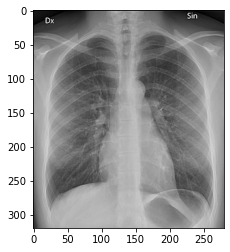

In [61]:
img_path = "../images/monalisa.jpg"
image =  mpimg.imread(img_path)
plt.imshow(image, cmap = "gray");

In [62]:
print("The image size is", image.shape)

The image size is (320, 280)


### Blocks of 8x8


In [63]:
def pad_image(image):
    '''Zero pads the image if necessary to be composed of 8x8 blocks
    
    Arguments: 
    image: a 2D numpy matrix 
    
    Returns:
    padded_image: a padded image with both dimensions as multiples of 8
    '''
    
    #initializing the padded dims to rows and cols
    row_padded, col_padded = image.shape
    
    #padding the rows if they are not multiples of 8
    if (row_padded % 8 != 0):
        row_padded = row_padded + (8 - row_padded % 8)
    #padding the cols 
    if (col_padded % 8 != 0):
        col_padded = col_padded + (8 - col_padded % 8)
    
    # if no padding happened, return the original image
    if (row_padded, col_padded) == image.shape:
        return image
    
    (row, col) = image.shape
    # initialize with new dims
    padded_image = np.zeros((row_padded, col_padded))
    
    # assign the old image to its right place
    padded_image[0:row, 0:col] = image
    
    return padded_image

In [64]:
def blockify(image):
    '''Returns a list of image blocks
    Arguments:
    image: a 2D matrix representing a matrix
    
    Returns
    blocks: a list of 8x8 blocks
    '''
    # zero pad if necessary
    image_padded = pad_image(image)
    # initialize the blocks list
    blocks = []
    # find out the number of blocks across each dim
    row, col = image_padded.shape
    n_block_row = int(row/8)
    n_block_col = int(col/8)
    # unenroll
    for i in range(n_block_row):
        for j in range(n_block_col):
            current_block = image_padded[i*8: (i+1)*8, j*8: (j+1)*8]
            blocks.append(current_block)
    
    return blocks, image_padded.shape

In [65]:
blocks, _ = blockify(image)
blocks[0]

array([[14, 14, 14, 13, 13, 13, 12, 12],
       [29, 29, 29, 28, 28, 28, 27, 27],
       [25, 25, 24, 24, 24, 23, 23, 23],
       [22, 22, 22, 22, 21, 21, 21, 20],
       [26, 25, 25, 25, 24, 24, 24, 23],
       [22, 22, 22, 22, 21, 21, 21, 20],
       [23, 23, 23, 22, 22, 22, 21, 21],
       [22, 22, 22, 22, 21, 21, 20, 20]], dtype=uint8)

## 2. Apply DCT to each block

In [66]:
DCT_blocks = []
for block in blocks:
    DCT_blocks.append(DCT_2D(block))
DCT_blocks[0]

array([[ 2.19687500e+01,  1.02210556e+00, -1.22490278e-01,
         4.78201890e-02, -8.83883476e-02,  4.94089482e-02,
         5.07371344e-02, -3.67894306e-02],
       [-5.50198601e-01, -1.82062761e-03,  9.07359364e-02,
         3.64347088e-02, -2.86091587e-03, -1.20669650e-01,
        -1.77927029e-16,  7.25072722e-02],
       [-2.17779937e+00,  4.33449952e-02, -4.95558262e-02,
        -2.98392507e-02, -3.38247563e-02, -2.36702034e-01,
         1.82138348e-01, -8.62185560e-03],
       [-2.16050969e+00, -1.50917505e-02,  3.68865862e-16,
         3.56453839e-02, -9.88831355e-02,  8.71718432e-02,
         6.63496461e-02,  3.16771796e-02],
       [-2.69584460e+00,  2.38425938e-02, -5.77424708e-02,
        -3.73796672e-03, -3.24554467e-16,  1.41390188e-01,
         2.39177145e-02, -5.35151673e-02],
       [-3.12733414e+00, -4.99830057e-02,  1.92210273e-16,
        -1.95223307e-02, -4.40553688e-02, -7.98395577e-02,
        -1.31977652e-02,  2.91024233e-02],
       [-2.25506428e+00, -2.509666

## 3. Applying quantization


In [67]:
q_blocks = []
for block in DCT_blocks:
    q_blocks.append(divide_quant(block))
q_blocks[0]

array([[21,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-2,  0,  0,  0,  0,  0,  0,  0],
       [-2,  0,  0,  0,  0,  0,  0,  0],
       [-2,  0,  0,  0,  0,  0,  0,  0],
       [-3,  0,  0,  0,  0,  0,  0,  0],
       [-2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

## 4. Unrolling each block into a vector

In [68]:
unrolled = []
for block in q_blocks:
    vector = block[ZIG_ZAG_ROW, ZIG_ZAG_COL]
    unrolled.append(vector)
unrolled[0]

array([21,  1,  0, -2,  0,  0,  0,  0,  0, -2, -2,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -3, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

## 5. Applying runlength code

In [69]:
rn_coded = []
for vector in unrolled:
    rn_coded.append(encode_runlength(vector))
rn_coded[0]

[21, 1, 0, 1, -2, 0, 5, -2, -2, 0, 9, -3, -2, 0, 42]

## 6. Applying Huffman code on the entire stream 


In [70]:
# obtaining the stream
stream = []
for rn in rn_coded:
    stream.extend(rn)

In [71]:
# applying huffman
huff_stream, huff_tree, huff_dict, symb_dict = encode_huffman(stream)

In [72]:
# printing the first 100 elements
huff_stream[0:100]

'0000000101110111110100111001110101010011100100111000101001101101100010000011111111011111010011100111'

### We can gather all of this in a single function

In [73]:
def encode_JPEG(image, q_table = ONES_TABLE):
    '''Performs JPEG compression on the image
    
    Arguments:
    image: a 2D matrix representing the grayscale image
    q_table: The qunatization table used while compressing
    
    Returns:
    huff_stream: The stream of bits obtained from the Huffman encoding
    huff_tree: The tree that holds the coding scheme. Essential for decoding
    huff_dict: A dictionary which maps each symbol to its assigned code by the Huffman code
    padded_shape: The size of the padded image. Will be usefull for reconstructing the image
    '''
    # dividing into blocks
    blocks, padded_shape = blockify(image)
    
    # initializing the stream
    stream = []
    # for each block
    for block in blocks:
        # applying 2D DCT
        DCT_block = DCT_2D(block)
        
        # dividing by quantization matrix
        q_block = divide_quant(DCT_block, q_table)
        
        # zigzag unrolling or spreading
        vector = q_block[ZIG_ZAG_ROW, ZIG_ZAG_COL]
        
        # Runlength
        rn_vector = encode_runlength(vector)
        
        # appending to stream
        stream.extend(rn_vector)
    
    # Now that we have the stream, apply huffman encoding
    huff_stream, huff_tree, huff_dict, symb_dict = encode_huffman(stream)
    
    return huff_stream, huff_tree, huff_dict, symb_dict, padded_shape

In [74]:
hf_stream, hf_tree, hf_dict, symbol_dict, image_dims = encode_JPEG(image)
len(hf_stream)

150752

In [75]:
print("Compression ratio is {}".format(image.shape[0] * image.shape[1] * 8 / len(hf_stream)))

Compression ratio is 4.75482912332838


# JPEG Decoder

## 7. Huffman Decoding
We will use the huffman tree we obtained earlier

In [76]:
decoded_hf_stream = decode_huffman(hf_stream, hf_tree)

## 8. RunLength Decoding 

In [77]:
decoded_rn_stream = decode_runlength(decoded_hf_stream)

## 9. ZigZag rolling


In [78]:
# separate every 64 element
vectors = []
n_vec = int(len(decoded_rn_stream) / 64)
for vec_index in range(n_vec):
    vector = decoded_rn_stream[vec_index * 64: (vec_index+1)*64]
    vectors.append(vector)

In [79]:
# roll each vector in a 2D matrix
blocks = []
for vector in vectors:
    rolled = np.empty((8,8))
    rolled[ZIG_ZAG_ROW, ZIG_ZAG_COL] = vector
    blocks.append(rolled)


## 10. Multiply by Quantization Table

In [80]:
qt_blocks = []
for block in blocks:
    qt_blocks.append(block * ONES_TABLE)
    

## 11. IDCT

In [81]:
ret_blocks = []
for block in qt_blocks:
    ret_blocks.append(IDCT_2D(block))

In [82]:
image_dims

(320, 280)

## 11 & 12.  IDCT and combining the image

In [83]:
regrouped = np.empty(image_dims)
n_block_col = int(image_dims[1]/8)
for index, block in enumerate(qt_blocks):
    row_index = int(index/n_block_col)
    col_index = index%n_block_col
    regrouped[row_index*8: (row_index+1)*8, col_index*8: (col_index+1)*8] = IDCT_2D(block)

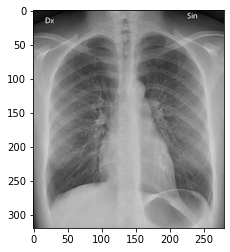

In [84]:
plt.imshow(regrouped, cmap="gray");

#### We can combine all of that in a single function 

In [85]:
def decode_jpeg(hf_stream, hf_tree, image_dims, q_table = ONES_TABLE):
    '''Decodes a Huffman stream into a 2D representation of grayscale image
    Arguments:
    hf_stream: The Stream of bits obtained from huffman code
    hf_tree: The Huffman tree to be used in decoding
    image_dims: The dimension of the image to be decoded
    q_table: The qunatization table that will be multipllied by each block before IDCT
    
    Returns:
    ret_image: The 2D decoded image
    '''
    # init the returned image
    ret_image = np.empty(image_dims)
    
    # The number of blocks along the columns
    n_block_col = int(image_dims[1]/8)
    
    # decode the huffman stream
    dec_hf = decode_huffman(hf_stream, hf_tree)
    
    # runlength decode
    dec_rn = decode_runlength(dec_hf)
    
    # Divide the decoded runlength into chunks of 64 elements
    # each rolled chunk will be multiplied by q_table and grouped into a decoded image
    n_chunks = int(len(dec_rn)/64)
    
    for i in range(n_chunks):
        chunk = dec_rn[i * 64: (i+1)*64]
        
        # roll it into a 2D matrix
        rolled = np.empty((8,8))
        rolled[ZIG_ZAG_ROW, ZIG_ZAG_COL] = chunk
        
        # multiply by q_table
        rolled = rolled * q_table
        
        # IDCT and grouping
        row_index = int(i/n_block_col)
        col_index = i %n_block_col
        ret_image[row_index*8: (row_index+1)*8, col_index*8: (col_index+1)*8] = IDCT_2D(rolled)
    
    return ret_image

In [86]:
h_stream, h_tree, h_dict, sym_dict, dims = encode_JPEG(image, q_table=LOW_COMPRESSION_MAT)
dec = decode_jpeg(h_stream, h_tree, dims, q_table=LOW_COMPRESSION_MAT)

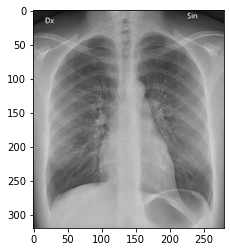

In [87]:
plt.imshow(dec, cmap="gray");

# Now That the JPEG Encoder / Decoder works, time for Specs definition

## Compression Ratio
After searching online for conventional compression ratios, using [this link as reference](https://ntrs.nasa.gov/citations/19920024689) which wikipedia cites,<br> it looks like `10:1` is an acceptable ratio

## Quality After compression
The quality after compression can be inspected by the RMSE between the image and the decoded image
I will set the image quality spec as:<br> RMSE < 5

## Testing different quantization tables on a Full HD image
First we want to convert it to grayscale

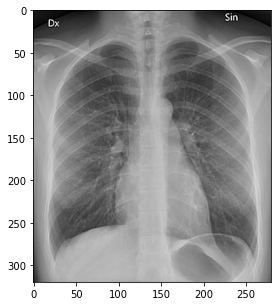

In [107]:
from PIL import Image
# converting it to grayscale 
hd_image = Image.open("../images/monalisa.jpg").convert("L")
hd_image = np.array(hd_image)
# Now we save it for reference
gray_hd = Image.fromarray(hd_image)
gray_hd.save("../Original_HD_grayscale.jpeg")
# Now we display it
plt.figure(figsize=(5,5))
plt.imshow(hd_image, cmap = "gray");

In [95]:
import time

### Ones Matrix

The code took 0.18185162544250488 seconds
Compression ratio is 4.75482912332838
The RMSE is 1.4856590914077583


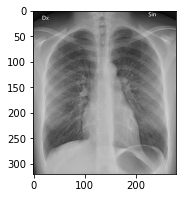

In [110]:
t = time.time()
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table=ONES_TABLE)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)

t =  time.time() - t
print("The code took {} seconds".format(t))
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(3,3))
plt.imshow(ret_image, cmap ="gray");

### High Compression Matrix

The code took 0.13958048820495605 seconds
Compression ratio is 15.91474245115453
The RMSE is 8.820684420136487


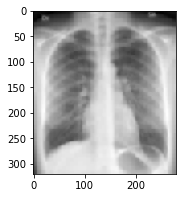

In [117]:
t = time.time()
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table=HIGH_COMPRESSION_MAT)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
t =  time.time() - t
print("The code took {} seconds".format(t))
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(3,3))
plt.imshow(ret_image, cmap ="gray");

- The compression ratio is very good! 
- But, The artefacts are indded visible. Image quality has visibly decreased
- RMSE is 7.9, which is not in our specs

### Low Compression Matrix

The code took 0.23641276359558105 seconds
Compression ratio is 5.050127873634077
The RMSE is 3.3703039215836506


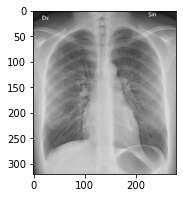

In [116]:
t = time.time()
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table=LOW_COMPRESSION_MAT)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
t =  time.time() - t
print("The code took {} seconds".format(t))
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(3,3))
plt.imshow(ret_image, cmap ="gray");

## So, it appears none of these tables is within our specs. I will try to design one on my own based on the previous tables
First we can try to multiply the low compression table by a scale, and see the result

Compression ratio is 8.246189243600805
The RMSE is 69.94585089027332


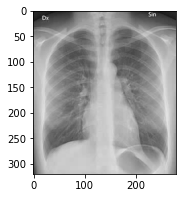

In [118]:
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table = LOW_COMPRESSION_MAT*2)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(3,3))
plt.imshow(ret_image, cmap ="gray");

## I have an idea! We can use zigzag in our design!


In [100]:
table = np.ones((64))
table[0:8] = 1
table[8:16] = 2
table[16:] = 256

qtble = np.empty((8,8))
qtble[ZIG_ZAG_ROW, ZIG_ZAG_COL] = table

In [101]:
qtble

array([[  1.,   1.,   1.,   1.,   2.,   2., 256., 256.],
       [  1.,   1.,   1.,   2., 256., 256., 256., 256.],
       [  1.,   2.,   2., 256., 256., 256., 256., 256.],
       [  2.,   2., 256., 256., 256., 256., 256., 256.],
       [  2., 256., 256., 256., 256., 256., 256., 256.],
       [256., 256., 256., 256., 256., 256., 256., 256.],
       [256., 256., 256., 256., 256., 256., 256., 256.],
       [256., 256., 256., 256., 256., 256., 256., 256.]])

Compression ratio is 8.781838452396997
The RMSE is 5.928749760445682


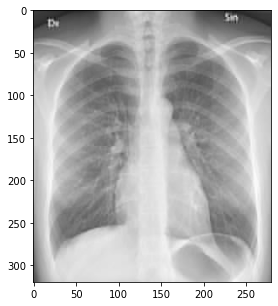

In [106]:
table = np.copy(LOW_COMPRESSION_MAT)
table[7, 0:3] = 128
table[7, 3:] = 256
table[0:3, 7] = 128
table[3:7, 7] = 256
table[2:, 2:] = 256
table = table * 2
table[0,0] /= 2
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table = qtble)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(5,5))
plt.imshow(ret_image, cmap ="gray");

# Spec Achieved!!


In [103]:
gray_hd_ret = Image.fromarray(ret_image.astype(np.uint8))
gray_hd_ret.save("../Compressed_with_specs.jpeg")

# Image before compression is `Original_HD_grayscale.jpeg`
# Image after compression is `Compressed_with_specs.jpeg`

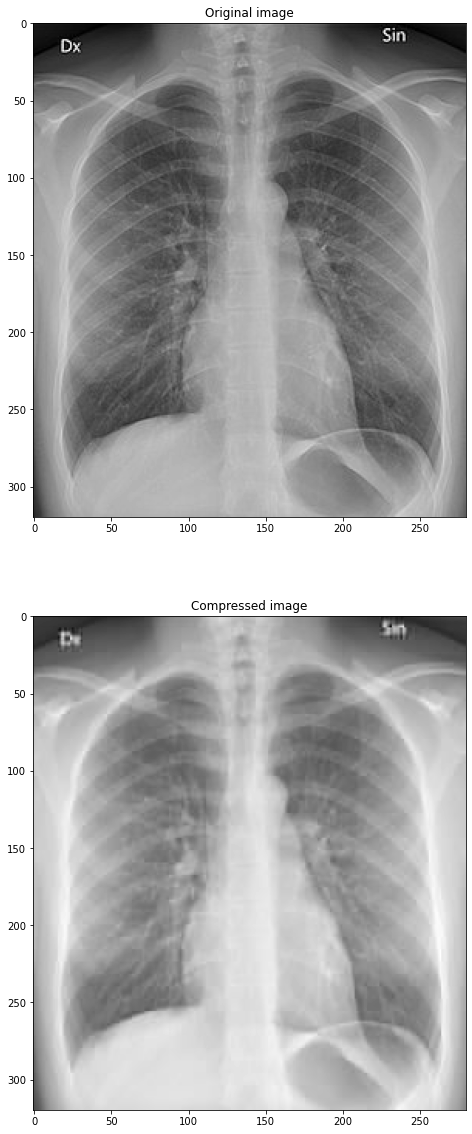

In [104]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,20));
ax1.imshow(hd_image, cmap = "gray");
ax1.set_title("Original image");
ax2.imshow(ret_image, cmap = "gray");
ax2.set_title("Compressed image");